# Свёрточные нейронные сети. Часть 1.

## Переключение версии TensorFlow

In [13]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [14]:
# %matplotlib inline  # Эта магическая команда для Jupyter Notebook: позволяет отображать графики прямо в блокноте.

import matplotlib.pyplot as plt  # Импортируем библиотеку для построения графиков и визуализации данных.
import numpy as np  # Импортируем библиотеку для работы с многомерными массивами и математическими операциями.

import tensorflow as tf  # Импортируем TensorFlow — библиотеку для создания и обучения нейронных сетей и работы с искусственным интеллектом.


## Загрузка и подготовка датасета MNIST

In [15]:
# Импортируем датасет MNIST — набор из 70,000 изображений рукописных цифр (от 0 до 9)
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

# train_x и test_x — массивы изображений размером 28x28 пикселей,
# но они имеют форму (кол-во_образцов, 28, 28), без канала цвета.
# Мы добавляем измерение канала (1), чтобы получилась форма (кол-во_образцов, 28, 28, 1).
# Это нужно, потому что многие нейронные сети ожидают 4D-вход (batch, height, width, channels).
train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

# Преобразование типа данных к float32 — для лучшей производительности и совместимости с TF.
# Делим на 255., чтобы нормализовать значения пикселей от 0-255 к диапазону 0-1.
# Это облегчает обучение нейросети и ускоряет сходимость.

# Выводим форму (shape) и тип данных (dtype) для тренировочных и тестовых данных.
print(train_x.shape, train_x.dtype)  # Ожидается: (60000, 28, 28, 1), float32
print(test_x.shape, test_x.dtype)    # Ожидается: (10000, 28, 28, 1), float32
print(train_y.shape, train_y.dtype)  # Ожидается: (60000,), uint8 — метки цифр 0-9
print(test_y.shape, test_y.dtype)    # Ожидается: (10000,), uint8


(60000, 28, 28, 1) float32
(10000, 28, 28, 1) float32
(60000,) uint8
(10000,) uint8


## Визуализация датасета MNIST

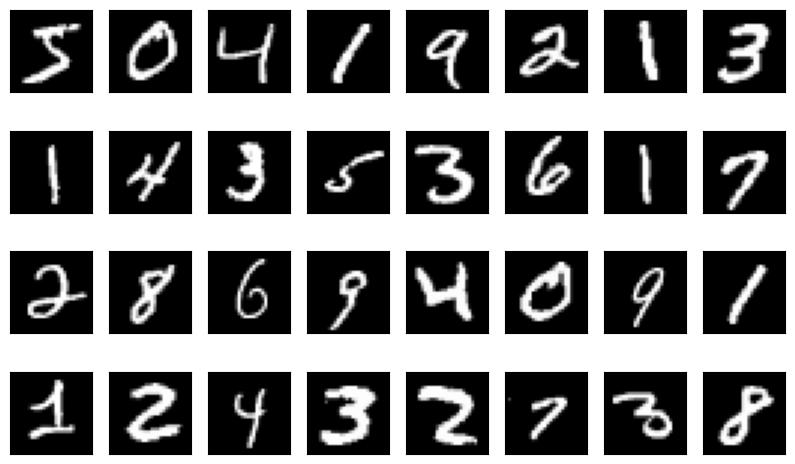

In [16]:
# Берём первые 32 изображения из обучающего набора train_x
some_samples = train_x[:32, ...]

# Создаём фигуру для графика с размером 10 на 6 дюймов
fig = plt.figure(figsize=(10, 6))

# Проходим по каждому изображению из выбранных 32 (shape[0] — количество изображений)
for j in range(some_samples.shape[0]):
    # Добавляем подграфик (subplot) в сетке 4 строки на 8 столбцов, позиция j+1
    ax = fig.add_subplot(4, 8, j+1)

    # Отображаем изображение j-го образца:
    # some_samples[j, :, :, 0] — j-е изображение, все пиксели по ширине и высоте, только первый канал (черно-белое)
    # cmap='gray' — показываем изображение в градациях серого
    ax.imshow(some_samples[j,:,:,0], cmap='gray')

    # Убираем отметки осей X и Y (чтобы не мешали просмотру)
    plt.xticks([]), plt.yticks([])

# Показываем все изображения на одном большом рисунке
plt.show()


## Создание модели CNN

In [4]:
model = tf.keras.models.Sequential([  # Создаем последовательную модель нейронной сети

    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    # 2D сверточный слой с 32 фильтрами размером 5x5,
    # 'padding="same"' означает, что выход будет того же размера, что и вход,
    # 'activation="relu"' — функция активации ReLU, которая добавляет нелинейность и помогает модели обучаться.

    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    # Слой подвыборки (максимум) с размером окна 2x2 и шагом 2x2,
    # уменьшает размер изображения в 2 раза по ширине и высоте,
    # выделяя важные признаки и снижая количество вычислений.

    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    # Еще один сверточный слой с 64 фильтрами 5x5, опять с сохранением размера,
    # который учится более сложным признакам изображения.

    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    # Второй слой подвыборки, который снова уменьшает размер признаков в 2 раза.

    tf.keras.layers.Flatten(),
    # Преобразует двумерный массив признаков в одномерный вектор,
    # чтобы подключить к полносвязным слоям.

    tf.keras.layers.Dense(256, activation='relu'),
    # Полносвязный (Dense) слой с 256 нейронами и ReLU активацией,
    # который учится обобщать признаки для классификации.

    tf.keras.layers.Dense(10, activation='softmax')
    # Выходной слой с 10 нейронами (например, для 10 классов объектов),
    # 'softmax' — функция активации, которая превращает выходы в вероятности классов,
    # сумма которых равна 1.
])


## Подготовка к обучению

In [18]:
model.compile(optimizer='sgd',                    # Устанавливаем алгоритм оптимизации для обучения модели — стохастический градиентный спуск (Stochastic Gradient Descent, SGD).
                                                # Это метод, который помогает модели улучшать свои предсказания, постепенно уменьшая ошибку.

              loss='sparse_categorical_crossentropy', # Задаём функцию потерь (loss function) — это мера того, насколько плохи предсказания модели.
                                                      # sparse_categorical_crossentropy используется, когда у нас несколько классов для классификации,
                                                      # и при этом целевые метки (правильные ответы) заданы как целые числа, а не в формате one-hot encoding.

              metrics=['accuracy'])                   # Указываем метрику для оценки качества модели во время обучения и проверки — точность (accuracy).
                                                      # Она показывает, какую долю примеров модель классифицировала правильно.


## Обучение модели

In [19]:
NUM_EPOCHS = 4  # Устанавливаем количество полных проходов по всему обучающему набору данных — "эпох" — равным 4

model.fit(train_x, train_y, epochs=NUM_EPOCHS)
# Запускаем обучение модели:
# model — это нейронная сеть, которую мы хотим обучить
# train_x — входные данные для обучения (например, изображения или их признаки)
# train_y — правильные ответы (метки) для этих данных (например, категории объектов)
# epochs=NUM_EPOCHS — указывает, что модель должна пройти через весь набор данных 4 раза, чтобы лучше научиться распознавать закономерности


Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 132s 70ms/step - accuracy: 0.7665 - loss: 0.8513
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 143s 70ms/step - accuracy: 0.9649 - loss: 0.1169
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 141s 70ms/step - accuracy: 0.9763 - loss: 0.0801
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 142s 70ms/step - accuracy: 0.9815 - loss: 0.0606


## Оценка качества модели

In [7]:
model.evaluate(test_x, test_y)
# model — это обученная нейронная сеть (модель), которая умеет делать предсказания.
# evaluate — функция, которая проверяет качество модели на новых данных.
# test_x — входные данные для тестирования (например, изображения).
# test_y — правильные ответы (метки классов) для этих данных.
# Когда вызываем model.evaluate, модель сравнивает свои предсказания с правильными ответами.
# В результате она возвращает численные показатели качества работы, например,
# потерю (loss) и точность (accuracy).
# Это помогает понять, насколько хорошо модель умеет распознавать объекты на новых данных.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9822 - loss: 0.0536


[0.046761274337768555, 0.9850000143051147]

## Пример инференса модели

In [8]:
sample = test_x[0, ...]                 # Берём первый элемент из массива test_x.
                                       # test_x — это, скорее всего, набор тестовых данных,
                                       # где каждый элемент — изображение или вход для модели.
                                       # Оператор [0, ...] означает "взять первый элемент и все остальные измерения".

prediction = model(sample[None, ...])[0]
                                       # Передаём этот элемент в модель для предсказания.
                                       # sample[None, ...] добавляет дополнительное измерение в начало,
                                       # чтобы сделать из одного образца "пакет" с одним элементом
                                       # (модели обычно ожидают на вход батч — несколько примеров).
                                       # model(...) — вызов модели, которая возвращает массив предсказаний для батча.
                                       # [0] — берём предсказание для первого (и единственного) элемента батча.

print(prediction)                      # Выводим предсказание модели для этого примера.


tf.Tensor(
[6.0043511e-08 4.1480327e-08 1.5588173e-05 4.8069658e-05 3.6326908e-09
 4.0409223e-08 2.2344743e-13 9.9993157e-01 2.0237799e-07 4.4782669e-06], shape=(10,), dtype=float32)


## Функция для инференса и отображения результата предсказания

In [9]:
def test_digit(sample):
    # model(sample[None, ...]) — вызываем модель для предсказания, добавляя размерность батча (None означает 1 элемент)
    # prediction — вероятности для каждой из 10 цифр (0-9) для данного образца
    prediction = model(sample[None, ...])[0]

    # np.argmax(prediction) — находим индекс максимального значения вероятности, то есть предсказанную цифру
    ans = np.argmax(prediction)

    # Создаем фигуру для отображения с размерами 12 на 4 дюйма
    fig = plt.figure(figsize=(12,4))

    # Первый подграфик (слева) — показываем исходное изображение цифры в оттенках серого
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:,:,0], cmap='gray')  # sample[:,:,0] — извлекаем одноцветный канал изображения
    plt.xticks([]), plt.yticks([])  # отключаем отображение делений осей

    # Второй подграфик (справа) — отображаем гистограмму вероятностей для всех 10 цифр
    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')  # создаем столбчатую диаграмму с вероятностями
    bar_list[ans].set_color('g')  # выделяем столбец с максимальной вероятностью зеленым цветом

    # Настраиваем ось X: метки от 0 до 9
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])  # немного расширяем границы по X, чтобы столбцы не прилипали к краям
    ax.grid(True)  # включаем сетку для удобства чтения графика

    # Показываем созданный график с изображением и гистограммой
    plt.show()

    # Выводим в консоль предсказанную цифру
    print('Predicted number: {}'.format(ans))


## Запуск предсказания для изображения случайной цифры из MNIST

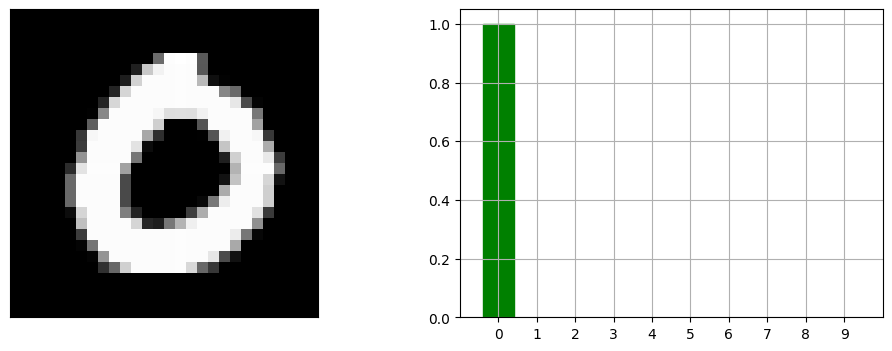

Predicted number: 0
True Answer: 0


In [10]:
import random  # Импортируем модуль random для работы со случайными числами

# Выбираем случайный индекс от 0 до количества элементов в массиве test_x (не включая верхнюю границу)
idx = random.randint(0, test_x.shape[0])

# Берём один пример из тестового набора test_x по случайному индексу idx
# test_x — это, предположительно, многомерный массив с изображениями,
# запись test_x[idx, ...] означает: взять элемент с индексом idx и все остальные измерения без изменений
sample = test_x[idx, ...]

# Вызываем функцию test_digit с выбранным примером sample
# test_digit — скорее всего, функция, которая принимает изображение и делает предсказание (например, какой цифре оно соответствует)
test_digit(sample)

# Выводим на экран "Истинный ответ" — правильный класс из test_y с индексом idx
# test_y — массив с правильными метками для тестовых данных, форматируем строку для удобного вывода
print('True Answer: {}'.format(test_y[idx]))


## Запуск предсказания на нашем изображении

In [11]:
def load_and_prepare_image(fpath):
    import imageio  # Импортируем библиотеку для чтения изображений из файла
    from skimage.transform import resize  # Импортируем функцию для изменения размера изображения

    img = imageio.imread(fpath, pilmode="RGB")
    # Считываем изображение из файла по пути fpath в формате RGB (цветное изображение с 3 каналами)

    img = img.astype(np.float32)/255
    # Преобразуем тип данных изображения в числа с плавающей точкой (float32) и нормируем значения пикселей к диапазону [0,1]
    # (изначально пиксели имеют целочисленное значение от 0 до 255)

    img = resize(img, (28, 28), order=3, mode='reflect', anti_aliasing=True)
    # Изменяем размер изображения на 28x28 пикселей с использованием кубической интерполяции (order=3)
    # Режим 'reflect' означает отражение пикселей по краям для заполнения при масштабировании
    # Антиалиасинг снижает искажения при уменьшении размера

    img = (1. - img).astype(np.float32)
    # Инвертируем цвета изображения: белые пиксели становятся черными и наоборот
    # Это нужно, потому что исходные данные MNIST — цифры белого цвета на черном фоне, а здесь наоборот

    img = np.mean(img, axis=2)
    # Преобразуем цветное изображение в оттенки серого, усредняя значения по трем цветовым каналам (R, G, B)

    img = np.reshape(img, (28, 28, 1))
    # Добавляем дополнительное измерение канала (1 канал), чтобы получить форму (высота, ширина, канал)
    # Это нужно для совместимости с нейронными сетями, которые ожидают 3D вход (например, CNN)

    return img  # Возвращаем подготовленное изображение — numpy массив размером 28x28x1 с нормированными и инвертированными значениями

if 1:
    !wget https://raw.githubusercontent.com/dkorobchenko-nv/dl-demo/master/mnist/digit.png
    # Команда для скачивания примера изображения цифры (digit.png) из интернета в текущую папку


--2025-07-08 18:56:30--  https://raw.githubusercontent.com/dkorobchenko-nv/dl-demo/master/mnist/digit.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16356 (16K) [image/png]
Saving to: ‘digit.png’

digit.png           100%[===================>]  15.97K  --.-KB/s    in 0.005s  

2025-07-08 18:56:31 (3.35 MB/s) - ‘digit.png’ saved [16356/16356]



/tmp/ipython-input-24-2788077141.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(fpath, pilmode="RGB")


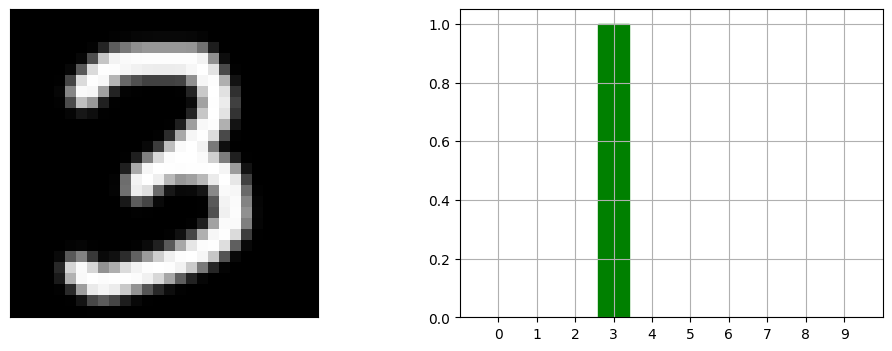

Predicted number: 3


In [25]:
# Здесь две функции вызываются подряд:

# 1. load_and_prepare_image('./digit.png')
# Эта функция загружает изображение из файла с именем 'digit.png' и подготавливает его к обработке.
# Обычно подготовка включает:
# - чтение изображения с диска,
# - преобразование в нужный формат (например, в оттенки серого),
# - изменение размера под требования модели (например, 28x28 пикселей для рукописных цифр),
# - нормализацию пикселей (приведение значений от 0 до 1 или от -1 до 1),
# - возможно, преобразование изображения в формат массива чисел (numpy array).

# Результат — подготовленное изображение, подходящее для подачи в модель.

img = load_and_prepare_image('./digit.png')  # Загружаем и готовим изображение

# 2. test_digit(img)
# Эта функция принимает подготовленное изображение и выполняет распознавание цифры на нем.
# Обычно она:
# - передает изображение в обученную модель нейронной сети,
# - получает предсказание (например, какая цифра изображена),
# - может вывести результат или вернуть его для дальнейшего использования.

test_digit(img)  # Распознаем цифру на подготовленном изображении
